In [1]:
from constants import CLEAN_PARQUET_DATA_ROOT, TASK1_OUT_ROOT
# import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
TEMP_PATH1 = "data/task1/all/year=2020"
TEMP_PATH2 = "data/task1/all/year=2021"
years = [2020, 2021]


In [2]:
dfs = [pd.read_parquet(TEMP_PATH1),
       pd.read_parquet(TEMP_PATH2)]
display(dfs[0])
display(dfs[1])

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.20,1,0,1,6.000000,3.0,...,1.47,0.00,0.3,11.270000,2.5,0.0,-73.973045,40.791706,-73.978630,40.783962
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.20,1,0,1,7.000000,3.0,...,1.50,0.00,0.3,12.300000,2.5,0.0,-73.978630,40.783962,-73.973045,40.791706
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.60,1,0,1,6.000000,3.0,...,1.00,0.00,0.3,10.800000,2.5,0.0,-73.973045,40.791706,-73.973045,40.791706
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1,0.80,1,0,1,5.500000,0.5,...,1.36,0.00,0.3,8.160000,0.0,0.0,-73.973045,40.791706,-73.968170,40.797962
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.00,1,0,2,3.500000,0.5,...,0.00,0.00,0.3,4.800000,0.0,0.0,-73.941994,40.760315,-73.941994,40.760315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24649087,2,2020-12-31 23:44:35,2021-01-01 00:01:22,0,9.22,99,-1,0,32.490002,0.0,...,8.16,0.00,0.3,43.950001,0.0,0.0,-73.987648,40.775967,-73.885864,40.857780
24649088,2,2020-12-31 23:41:36,2020-12-31 23:50:32,0,4.79,99,-1,0,13.220000,0.0,...,3.65,0.00,0.3,20.170000,0.0,0.0,-73.976967,40.723751,-73.946510,40.775932
24649089,2,2020-12-31 23:01:17,2020-12-31 23:40:37,0,28.00,99,-1,0,69.309998,0.0,...,2.75,6.12,0.3,78.980003,0.0,0.0,-73.940506,40.592022,-73.885521,40.844959
24649090,2,2020-12-31 23:31:29,2020-12-31 23:44:22,0,7.08,99,-1,0,35.950001,0.0,...,2.75,0.00,0.3,39.500000,0.0,0.0,-73.990898,40.718937,-73.885315,40.757313


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1,2.10,1,0,2,8.000000,3.0,...,0.00,0.0,0.3,11.800000,2.5,0.0,-73.981529,40.773632,-73.965553,40.782478
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,0,2,3.000000,0.5,...,0.00,0.0,0.3,4.300000,0.0,0.0,-73.973045,40.791706,-73.968170,40.797962
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1,14.70,1,0,1,42.000000,0.5,...,8.65,0.0,0.3,51.950001,0.0,0.0,-73.786530,40.646984,-73.956825,40.620922
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0,10.60,1,0,1,29.000000,0.5,...,6.05,0.0,0.3,36.349998,0.0,0.0,-73.873627,40.774376,-73.786530,40.646984
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1,4.94,1,0,1,16.500000,0.5,...,4.06,0.0,0.3,24.360001,2.5,0.0,-73.999916,40.748428,-73.995247,40.695797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30904303,2,2021-12-31 23:18:02,2021-12-31 23:32:19,0,3.99,99,-1,0,17.420000,0.0,...,5.80,0.0,0.3,26.520000,0.0,0.0,-73.948891,40.745380,-73.984055,40.736824
30904304,2,2021-12-31 23:46:00,2022-01-01 00:07:00,0,5.96,99,-1,0,23.049999,0.0,...,2.85,0.0,0.3,29.200001,0.0,0.0,-73.957008,40.780437,-74.008987,40.735035
30904305,2,2021-12-31 23:46:00,2022-01-01 00:04:00,0,4.99,99,-1,0,20.969999,0.0,...,5.23,0.0,0.3,29.500000,0.0,0.0,-73.989845,40.762253,-74.016083,40.712036
30904306,2,2021-12-31 23:53:00,2022-01-01 00:02:00,0,1.36,99,-1,0,13.200000,0.0,...,2.00,0.0,0.3,16.000000,0.0,0.0,-73.945747,40.790012,-73.945747,40.790012


In [3]:
dfs[0].columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'rate_code_id', 'store_and_fwd_flag', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'airport_fee', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude'],
      dtype='object')

In [4]:
dfs[0].dtypes

vendor_id                          int8
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
passenger_count                   uint8
trip_distance                   float32
rate_code_id                      uint8
store_and_fwd_flag                 int8
payment_type                      uint8
fare_amount                     float32
extra                           float32
mta_tax                         float32
tip_amount                      float32
tolls_amount                    float32
improvement_surcharge           float32
total_amount                    float32
congestion_surcharge            float32
airport_fee                     float32
pickup_longitude                float32
pickup_latitude                 float32
dropoff_longitude               float32
dropoff_latitude                float32
dtype: object

## Cleaning
Filter rows based on:
- pickup/dropoff datetimes s.t.:
    - pickup is before dropoff at all times
    - in case where pickup is a year before the dropoff, we keep the rows where pickup was on the last day of the previous/current year and dropoff was on the first day of the current/next year.
- trip distance s.t.:
    - is positive
    - is within achievable range given 80mph for the given distance and computed trip duration based on dropoff - pickup.
= trip duration s.t.:
    - is positive (atleast 1min)
    - is within generous bounds (1min, 4hours)
- pickup/dropoff longitude/latitude
    - where either are NaN (not given)
    - are in reasonable bounds based on bbox given by: https://www.nyc.gov/assets/planning/download/pdf/data-maps/open-data/meta_nhood.pdf 
- prices:
    - positive for mandatory, nonegative for tips/surcharges
    - total_amount has to be atleast equal or larget to the sum of all charges (tips/extras not included)

In [5]:
NYC_MOST_WEST_LONGITUDE = -74.248064
NYC_MOST_EAST_LONGITUDE = -73.708116
NYC_MOST_NORTH_LATITUDE = 40.908582
NYC_MOST_SOUTH_LATITUDE = 40.505232

MAX_SPEED = 80 # mph
REASONABLE_PRICE_MIN = 2.5 # initial charge
REASONABLE_PRICE_MAX = 500
REASONABLE_MIN_TRIP_DURATION = 1 # in minutes
REASONABLE_MAX_TRIP_DURATION = 6 * 60 # in minutes
REASONABLE_MIN_YEAR = 2008 # first year of NYC taxi data -1 (trips with pickup on 2008-12-31)
REASONABLE_MAX_YEAR = 2025 # last year of NYC taxi data

for i in range(len(dfs)):
    # Pickup/Dropoff datetimes cleaning
    dfs[i]['year'] = dfs[i]['pickup_datetime'].dt.year.astype(np.int16)
    pickup_before_dropoff = dfs[i]['pickup_datetime'] < dfs[i]['dropoff_datetime']
    delta_years = (dfs[i]['dropoff_datetime'].dt.year - dfs[i]['pickup_datetime'].dt.year)
    same_year = delta_years == 0
    dropoff_next_year = (delta_years == 1) & (dfs[i]['dropoff_datetime'].dt.month == 1) & (dfs[i]['dropoff_datetime'].dt.day == 1) & (dfs[i]['pickup_datetime'].dt.month == 12) & (dfs[i]['pickup_datetime'].dt.day == 31)
    reasonable_year = dfs[i]['year'].between(REASONABLE_MIN_YEAR, REASONABLE_MAX_YEAR, inclusive='both')
    correct_datetimes = pickup_before_dropoff & (same_year | dropoff_next_year) & reasonable_year

    # Trip distance cleaning
    trip_duration = (dfs[i]['dropoff_datetime'] - dfs[i]['pickup_datetime']).dt.total_seconds() / (60 * 60) # in hours
    achievable_trip_distance = trip_duration * MAX_SPEED
    reasonable_trip_duration = trip_duration.between(REASONABLE_MIN_TRIP_DURATION / 60, REASONABLE_MAX_TRIP_DURATION / 60) # in hours
    valid_trips = dfs[i]['trip_distance'].between(0, achievable_trip_distance, inclusive='neither') & reasonable_trip_duration
    
    # Coordinates cleaning
    latitudes_not_nan = dfs[i]['pickup_latitude'].notna() & dfs[i]['dropoff_latitude'].notna()
    longitudes_not_nan = dfs[i]['pickup_longitude'].notna() & dfs[i]['dropoff_longitude'].notna()
    latitudes_within_bounds = (dfs[i]['pickup_latitude'].between(NYC_MOST_SOUTH_LATITUDE, NYC_MOST_NORTH_LATITUDE) & dfs[i]['dropoff_latitude'].between(NYC_MOST_SOUTH_LATITUDE, NYC_MOST_NORTH_LATITUDE))
    longitudes_within_bounds = (dfs[i]['pickup_longitude'].between(NYC_MOST_WEST_LONGITUDE, NYC_MOST_EAST_LONGITUDE) & dfs[i]['dropoff_longitude'].between(NYC_MOST_WEST_LONGITUDE, NYC_MOST_EAST_LONGITUDE))
    coordinates_reasonable = latitudes_not_nan & longitudes_not_nan & latitudes_within_bounds & longitudes_within_bounds
    
    # Price cleaning
    positive_fare = dfs[i]['fare_amount'] > 2.5 # initial charge
    nonnegative_extra = dfs[i]['extra'] >= 0
    nonnegative_mta = dfs[i]['mta_tax'] >= 0
    nonnegative_tip = dfs[i]['tip_amount'] >= 0
    nonnegative_tolls = dfs[i]['tolls_amount'] >= 0
    nonnegative_improvement = dfs[i]['improvement_surcharge'] >= 0
    nonnegative_congestion = dfs[i]['congestion_surcharge'] >= 0
    nonnegative_airport_fee = dfs[i]['airport_fee'] >= 0
    positive_total = dfs[i]['total_amount'] > 0
    reasonable_sum = (
        dfs[i]['fare_amount'] +
        # dfs[i]['extra'] +
        # dfs[i]['tip_amount'] +
        dfs[i]['mta_tax'] +
        dfs[i]['improvement_surcharge'] +
        dfs[i]['tolls_amount'] +
        dfs[i]['congestion_surcharge'] +
        dfs[i]['airport_fee']).between(0, dfs[i]['total_amount'], inclusive='right')
    reasonable_price = dfs[i]['total_amount'].between(REASONABLE_PRICE_MIN, REASONABLE_PRICE_MAX, inclusive='both')
    valid_prices = positive_fare & nonnegative_extra & nonnegative_mta & nonnegative_tip & nonnegative_tolls & nonnegative_improvement & nonnegative_congestion & nonnegative_airport_fee & positive_total & reasonable_price & reasonable_sum
    
    # Apply all filters
    clean_mask = correct_datetimes & valid_trips & coordinates_reasonable & valid_prices
    display(dfs[i][~clean_mask])
    dfs[i] = dfs[i][clean_mask].reset_index(drop=True)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.00,1,0,2,3.500000,0.5,...,0.0,0.3,4.80,0.0,0.0,-73.941994,40.760315,-73.941994,40.760315,2020
5,2,2020-01-01 00:09:44,2020-01-01 00:10:37,1,0.03,1,0,2,2.500000,0.5,...,0.0,0.3,3.80,0.0,0.0,-73.919693,40.761494,-73.941994,40.760315,2020
6,2,2020-01-01 00:39:25,2020-01-01 00:39:29,1,0.00,1,0,1,2.500000,0.5,...,0.0,0.3,3.81,0.0,0.0,-73.941994,40.760315,-73.941994,40.760315,2020
7,2,2019-12-18 15:27:49,2019-12-18 15:28:59,1,0.00,5,0,1,0.010000,0.0,...,0.0,0.3,2.81,2.5,0.0,-73.941994,40.760315,-73.941994,40.760315,2019
8,2,2019-12-18 15:30:35,2019-12-18 15:31:35,4,0.00,1,0,1,2.500000,0.5,...,0.0,0.3,6.30,2.5,0.0,-73.941994,40.760315,-73.941994,40.760315,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24649069,1,2020-12-31 23:33:41,2020-12-31 23:43:17,0,0.00,99,-1,0,10.200000,0.5,...,0.0,0.3,16.00,0.0,0.0,-73.968170,40.797962,-74.004013,40.753307,2020
24649073,6,2020-12-31 23:12:42,2020-12-31 23:12:02,0,10.06,99,-1,0,28.600000,0.0,...,0.0,0.3,29.40,0.0,0.0,NaN,NaN,-73.931885,40.688168,2020
24649080,6,2020-12-31 23:12:59,2020-12-31 23:12:04,0,15.21,99,-1,0,37.700001,0.0,...,0.0,0.3,38.50,0.0,0.0,NaN,NaN,-73.739471,40.657852,2020
24649083,2,2020-12-31 23:14:37,2020-12-31 23:15:21,0,0.00,99,-1,0,13.000000,0.0,...,0.0,0.3,13.30,0.0,0.0,-73.986115,40.685635,-73.986115,40.685635,2020


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1,0.20,1,0,2,3.000000,0.5,...,0.00,0.3,4.300000,0.0,0.0,-73.973045,40.791706,-73.968170,40.797962,2021
34,2,2021-01-01 00:19:57,2021-01-01 00:43:03,3,10.74,1,0,1,32.500000,0.5,...,0.00,0.3,40.299999,2.5,0.0,NaN,NaN,-74.007881,40.717773,2021
38,1,2021-01-01 00:03:13,2021-01-01 00:03:19,1,0.00,1,0,3,0.000000,0.0,...,0.00,0.0,0.000000,0.0,0.0,-73.905121,40.849060,-73.905121,40.849060,2021
39,1,2021-01-01 00:52:42,2021-01-01 01:04:49,1,0.00,1,0,1,17.200001,0.0,...,0.00,0.3,18.000000,0.0,0.0,-73.973045,40.791706,-73.940773,40.818256,2021
48,1,2021-01-01 00:37:06,2021-01-01 00:42:58,1,1.40,1,0,1,6.500000,3.0,...,0.00,0.3,12.300000,2.5,0.0,NaN,NaN,-73.973045,40.791706,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30904249,6,2021-12-31 22:12:41,2021-12-31 22:12:05,0,3.69,99,-1,0,34.200001,0.0,...,0.00,0.3,35.000000,0.0,0.0,NaN,NaN,-73.968910,40.661621,2021
30904255,1,2021-12-31 22:52:08,2021-12-31 23:00:37,0,0.00,99,-1,0,7.200000,0.5,...,0.00,0.3,14.100000,0.0,0.0,-74.002876,40.734577,-73.996918,40.720890,2021
30904267,2,2021-12-31 23:21:00,2021-12-31 23:37:00,0,4.55,99,-1,0,22.790001,0.0,...,11.75,0.3,38.689999,0.0,0.0,-74.002876,40.734577,NaN,NaN,2021
30904286,1,2021-12-31 23:30:21,2021-12-31 23:59:28,0,0.00,99,-1,0,27.200001,0.5,...,0.00,0.3,37.650002,0.0,0.0,-73.949905,40.691505,-73.970444,40.749912,2021


In [6]:
# compute aggregates
for i in range(len(dfs)):
    display(dfs[i].describe())

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year
count,2.381594e+07,23815936,23815936,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,...,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,23815936.0,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07,2.381594e+07
mean,1.677071e+00,2020-04-30 03:04:33.973920,2020-04-30 03:17:30.594602752,1.426845e+00,2.879632e+00,4.033954e+00,-2.111935e-02,1.229381e+00,1.228197e+01,1.072490e+00,...,2.850578e-01,2.999519e-01,1.804464e+01,2.250710e+00,0.0,-7.396947e+01,4.075479e+01,-7.397035e+01,4.075606e+01,2.020000e+03
min,-1.000000e+00,2008-12-31 22:20:23,2008-12-31 22:55:19,0.000000e+00,1.000000e-02,1.000000e+00,-1.000000e+00,0.000000e+00,2.510000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,3.300000e+00,0.000000e+00,0.0,-7.423354e+01,4.052549e+01,-7.423354e+01,4.052549e+01,2.008000e+03
25%,1.000000e+00,2020-01-30 20:53:48,2020-01-30 21:07:15,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,...,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,0.0,-7.398985e+01,4.074044e+01,-7.398985e+01,4.074034e+01,2.020000e+03
50%,2.000000e+00,2020-02-28 06:17:24,2020-02-28 06:28:58,1.000000e+00,1.680000e+00,1.000000e+00,0.000000e+00,1.000000e+00,9.000000e+00,5.000000e-01,...,0.000000e+00,3.000000e-01,1.416000e+01,2.500000e+00,0.0,-7.397849e+01,4.075803e+01,-7.397770e+01,4.075803e+01,2.020000e+03
75%,2.000000e+00,2020-08-25 20:24:02.500000,2020-08-25 20:35:14.750000128,1.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,2.000000e+00,1.350000e+01,2.500000e+00,...,0.000000e+00,3.000000e-01,1.965000e+01,2.500000e+00,0.0,-7.396515e+01,4.077363e+01,-7.395963e+01,4.077593e+01,2.020000e+03
max,2.000000e+00,2021-06-10 10:10:48,2021-06-10 10:41:42,9.000000e+00,1.671000e+02,9.900000e+01,1.000000e+00,5.000000e+00,4.700000e+02,1.130100e+02,...,2.666800e+02,3.000000e-01,4.998000e+02,2.750000e+00,0.0,-7.371103e+01,4.089953e+01,-7.371103e+01,4.089953e+01,2.021000e+03
std,4.676237e-01,NaN,NaN,1.128453e+00,3.571875e+00,1.690913e+01,1.996233e-01,5.034336e-01,1.024588e+01,1.242950e+00,...,1.430784e+00,3.719238e-03,1.237405e+01,7.490472e-01,0.0,3.928520e-02,3.066244e-02,3.494987e-02,3.337810e-02,1.968320e-02


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,payment_type,fare_amount,extra,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year
count,2.973011e+07,29730114,29730114,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,...,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07,2.973011e+07
mean,1.698015e+00,2021-07-28 21:21:37.309829120,2021-07-28 21:35:41.487300864,1.368263e+00,3.159028e+00,5.385241e+00,-3.085992e-02,1.179748e+00,1.312705e+01,1.070422e+00,...,3.682355e-01,2.999867e-01,1.935695e+01,2.237082e+00,5.754481e-02,-7.396838e+01,4.075430e+01,-7.396954e+01,4.075571e+01,2.021000e+03
min,-1.000000e+00,2008-12-31 16:15:09,2008-12-31 16:23:09,0.000000e+00,1.000000e-02,1.000000e+00,-1.000000e+00,0.000000e+00,2.540000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,-7.423354e+01,4.052549e+01,-7.423354e+01,4.052549e+01,2.008000e+03
25%,1.000000e+00,2021-05-12 15:01:01,2021-05-12 15:15:44.249999872,1.000000e+00,1.100000e+00,1.000000e+00,0.000000e+00,1.000000e+00,6.500000e+00,0.000000e+00,...,0.000000e+00,3.000000e-01,1.176000e+01,2.500000e+00,0.000000e+00,-7.398985e+01,4.074044e+01,-7.398985e+01,4.074034e+01,2.021000e+03
50%,2.000000e+00,2021-08-06 08:39:12.500000,2021-08-06 08:51:48.500000,1.000000e+00,1.830000e+00,1.000000e+00,0.000000e+00,1.000000e+00,9.500000e+00,5.000000e-01,...,0.000000e+00,3.000000e-01,1.530000e+01,2.500000e+00,0.000000e+00,-7.397770e+01,4.075803e+01,-7.397770e+01,4.075803e+01,2.021000e+03
75%,2.000000e+00,2021-10-23 00:37:41.750000128,2021-10-23 00:50:59.750000128,1.000000e+00,3.300000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.450000e+01,2.500000e+00,...,0.000000e+00,3.000000e-01,2.080000e+01,2.500000e+00,0.000000e+00,-7.396515e+01,4.077363e+01,-7.395963e+01,4.077593e+01,2.021000e+03
max,2.000000e+00,2022-03-14 11:17:03,2022-03-14 11:24:37,1.120000e+02,2.112400e+02,9.900000e+01,1.000000e+00,5.000000e+00,4.885000e+02,4.107000e+01,...,2.161200e+02,3.000000e-01,4.948000e+02,2.750000e+00,1.250000e+00,-7.371103e+01,4.089953e+01,-7.371103e+01,4.089953e+01,2.022000e+03
std,4.591279e-01,NaN,NaN,1.055008e+00,3.843034e+00,2.019437e+01,2.377464e-01,4.990556e-01,1.084419e+01,1.256366e+00,...,1.617024e+00,1.779431e-03,1.350851e+01,7.669176e-01,2.619534e-01,4.221254e-02,3.107284e-02,3.504689e-02,3.280485e-02,2.913876e-02


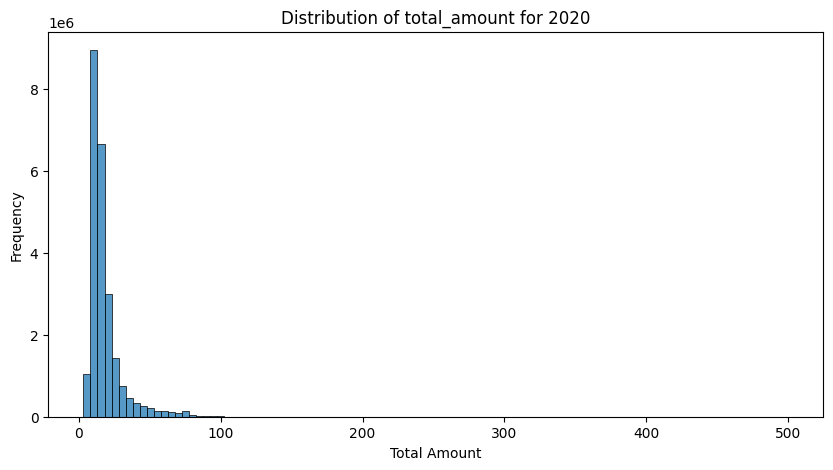

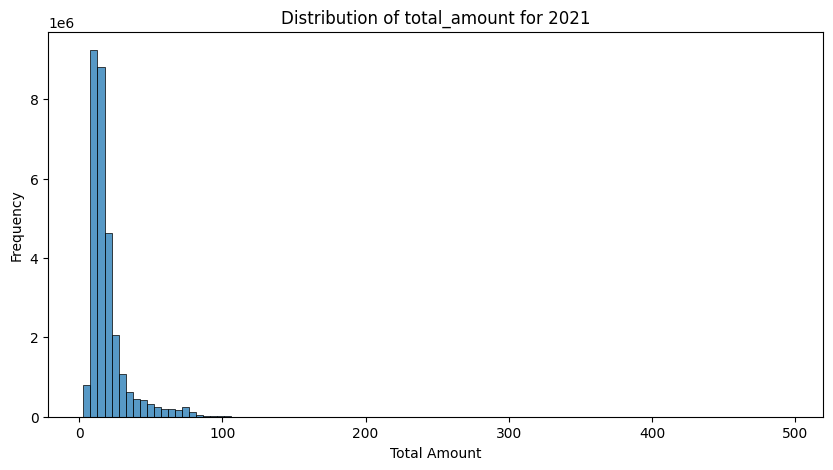

In [7]:
# dist of total_amoun
for i in range(len(dfs)):
    plt.figure(figsize=(10, 5))
    sns.histplot(dfs[i]['total_amount'], bins=100)
    plt.title(f"Distribution of total_amount for {years[i]}")
    plt.xlabel("Total Amount")
    plt.ylabel("Frequency")
    plt.show()

In [8]:
# show the top 10 longest trips
for i in range(len(dfs)):
    print(dfs[i].nlargest(10, 'total_amount'))

          vendor_id     pickup_datetime    dropoff_datetime  passenger_count  \
5592336           2 2020-01-29 15:35:29 2020-01-29 16:02:31                1   
22226965          1 2020-11-28 10:05:20 2020-11-28 10:24:55                4   
18846132          2 2020-09-21 16:55:15 2020-09-21 17:06:01                1   
19726143          1 2020-10-08 22:02:51 2020-10-08 22:07:10                0   
15695463          2 2020-05-22 19:25:04 2020-05-22 19:52:37                1   
11843392          2 2020-02-27 23:01:46 2020-02-27 23:06:47                1   
12880166          2 2020-03-03 19:57:16 2020-03-03 20:19:08                1   
16284013          1 2020-06-30 05:50:57 2020-06-30 10:29:09                1   
11650009          2 2020-02-27 09:51:32 2020-02-27 09:54:55                1   
53319             1 2020-01-01 04:06:21 2020-01-01 04:22:57                1   

          trip_distance  rate_code_id  store_and_fwd_flag  payment_type  \
5592336        3.840000             1       